In [1]:
import pandas as pd
import seaborn as sns
import nltk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')

df = pd.read_csv("full_cleaned_data.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df

,Name,Street,Price Tags,Average Rating,Review text,Category 1,Category 2,Customer Satisfaction
0,THE FARMHOUSE TAP & GRILL,Bank St,2.0,4.0,julie another wonderful experience farmhouse! ...,burgers,tradamerica,High
1,HEN OF THE WOOD,NaN,3.0,4.5,"cozy interior, fresh (we saw farmer drop stack...",newamerican,NaN,High
2,THE GRYPHON,Main St,2.0,4.5,"best brunch. bloody mary'#39's die for, love u...",nightlife,newamerican,High
3,JUNIPER BAR & RESTAURANT,Cherry St,2.0,4.0,met family crazy thanksgiving weekend. great p...,tradamerica,NaN,High
4,HONEY ROAD,Church St,2.0,4.5,review mentioned difficult get reservation res...,NaN,NaN,High
...,...,...,...,...,...,...,...,...
105,KRU COFFEE,Church St,1.0,4.5,stopped last day struggling decide grab coffee...,coffee,sandwiche,High
106,HALVORSON’S UPSTREET CAFE,Church St,2.0,3.0,great food. cozy atmosphere. made reservations...,tradamerica,beer_and_wine,Low
107,PIESANOS,Main St,2.0,3.0,"1 1/2 hour delivery wait...i get it, it'#39's ...",pizza,italian,Low
108,KESTREL COFFEE ROASTERS,Maple St,NaN,4.5,sweet little roastery free short term streetsi...,cafes,coffee,High


<AxesSubplot:xlabel='Customer Satisfaction', ylabel='count'>

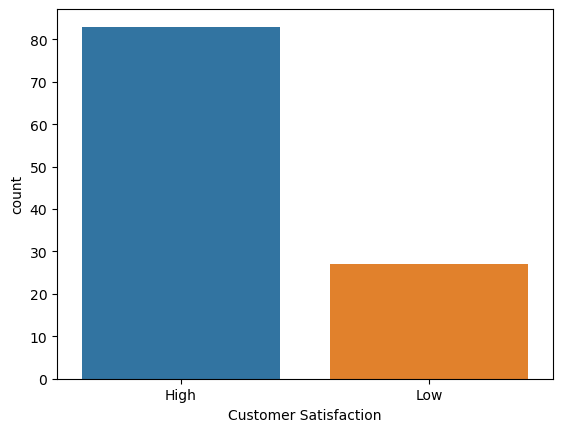

In [2]:
sns.countplot(x='Customer Satisfaction', data=df)
#unbalanced

In [3]:
def remove_punctuation(text):
    # initializing punctuations string
    punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    #get rid o
    for char in text:
        if char in punctuation:
            clean_text = text.replace(char, '')
    return clean_text

In [4]:
def select_columns(data, *columns):
 
    """Select only columns passed as arguments."""

    return data.loc[:, columns]

In [5]:
def process_data(data):
 
    # Transform Data, Select Features
    data = select_columns(data,'Street','Price Tags', 'Review text', 'Category 1', 'Category 2', 'Customer Satisfaction')
    
    #turn y ('Customer Satisfaction') into either 1 or 0
    df['Customer Satisfaction'] = df['Customer Satisfaction'].map({'High': 1, 'Low': 0})
    
    return data

In [6]:
def fix_missing(df):
    '''Function to fill in missing data with the mode'''
    
    #find the modes
    modes = df.mode()
    mode_list = modes.values.tolist()[0]
    
    
    df[['Street']] = df[['Street']]. fillna(str(mode_list[0]))
    df[['Price Tags']] = df[['Price Tags']]. fillna(str(mode_list[1]))
    df[['Category 1']] = df[['Category 1']]. fillna(str(mode_list[3]))
    df[['Category 2']] = df[['Category 2']]. fillna(str(mode_list[4]))
    
    return df

In [7]:
def reset_index(df):
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    return df

In [8]:
def get_predictor_response_vars(data):
    # Return predictors and response variables separately
    x = data.drop(['Customer Satisfaction'], axis = 1)
    y = data.loc[:, 'Customer Satisfaction']
    
    return x, y
    


In [9]:
def one_hot_encoding(df, column_name):
    '''Returns df with chosen column replaced by one hot encoding'''
    from sklearn.feature_extraction.text import CountVectorizer
    #fit vectorizer to data
    vectorizer = CountVectorizer()
    vectorizer.fit_transform(df[column_name])
    
    #convert into array of numbers
    numbers = vectorizer.transform(df[column_name])
    words = vectorizer.get_feature_names_out()
    one_hot = pd.DataFrame(numbers.toarray(), columns=words)

    #add one-hot to original df, get rid of review text
    df = df.drop([column_name], axis=1)
    full_df = pd.concat([df, one_hot], axis=1)
    return full_df

In [10]:
#get text ready for training and test set by cleaning punctuation
reviews_clean = []
reviews = list(df["Review text"])
for review in reviews:
    reviews_clean.append(remove_punctuation(review))
#delete old review text
df.drop(['Review text'], axis=1)
df = pd.concat([df, pd.DataFrame(reviews_clean, columns= ['Review text'])], axis=1)


In [11]:
#preprocessing data
df = process_data(df)
df = fix_missing(df)

df.isnull().values.any()


False

In [12]:
#get data ready for classification model by...

# #preprocessing data
# df = process_data(df)
# df = fix_missing(df)

#turning all text into numerical values
#street column
df = one_hot_encoding(df, 'Street')
#review text column
df = one_hot_encoding(df, 'Review text')
#catgory 1 column
df = one_hot_encoding(df, 'Category 1')
#category 2 column
df = one_hot_encoding(df, 'Category 2')

#customer satisfaction
df['Customer Satisfaction'] = df['Customer Satisfaction'].replace('High', 1)
df['Customer Satisfaction'] = df['Customer Satisfaction'].replace('Low', 0)


In [29]:
#look to see where there are NaNS (can't have this when training model)
sum = 0
for (colname,colval) in df.iteritems():
    if df[colname].isnull().values.any():
        pass
    
#drop these columns
df = df.drop(['review'], axis=1)
df = df.drop(['text'], axis=1)

sum = 0
for (colname,colval) in df.iteritems():
    if df[colname].isnull().values.any():
        print(colname)
    

In [30]:
#split the data
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, train_size=.8, random_state=42)

x_train, y_train = get_predictor_response_vars(train)
x_val, y_val = get_predictor_response_vars(val)

In [31]:
#reset indices
x_train = reset_index(x_train)
y_train = reset_index(y_train)
y_train
x_train

,Price Tags,ave,bank,battery,center,champlain,cherry,church,colchester,college,...,newamerican,nightlife,noodles,pizza,pubs,sala,sandwiche,soup,tradamerica,wine_bar
0,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,2.0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
85,2.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
86,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [33]:
#fit model to our training data
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
#train random forest model
random_forest.fit(x_train, y_train.values.ravel())
#change array shape with .values.ravel()

RandomForestClassifier()

In [39]:
#test
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
y_pred = random_forest.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8181818181818182


In [46]:
# #look at some decision trees
# from sklearn.tree import export_graphviz
# from IPython.display import Image
# #import graphviz

# for i in range(3):
#     tree = random_forest.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=x_train.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)

NameError: name 'graphviz' is not defined